# Graphless

#### Import statements
Used to import local functions/modules or external libraries inside the notebook.

In [1]:
from ola2022_project.environment.environment import example_environment, Step, UserClassParameters
from ola2022_project.simulation.simulation import Simulation, create_n, simulate_n
from ola2022_project.learners import *
from ola2022_project.algorithms.multi_armed_bandits import Mab
from ola2022_project.algorithms.reward_estimator import clairvoyant_reward

import numpy as np
import matplotlib.pyplot as plt
import random

plt.style.use('seaborn-v0_8-dark')

#### Plotting functions
Functions used to plot data onto a graph for an immediate visualization and analysis.

In [2]:
def compute_regret(rewards, avg_clairvoyant_reward):
    regret = avg_clairvoyant_reward - rewards
    regret[regret<0] = 0
    return np.cumsum(regret)


In [3]:
# Function used for quickly plotting multiple experiments onto a graph
def plot_experiment(n_days, rewards, avg_clairvoyant_reward, title, reward_color='cornflowerblue', regret_color='salmon'):

    regret_plot = compute_regret(rewards, avg_clairvoyant_reward)
    clairvoyant_plot = np.ones(len(rewards)) * avg_clairvoyant_reward

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

    ax[0].plot(rewards, color=reward_color, label='Rewards')
    ax[0].title.set_text(f'{title} reward')
    ax[0].plot(clairvoyant_plot, color=reward_color, linestyle='--', label='Average clairvoyant reward')
    ax[0].legend(loc='best')

    ax[1].plot(regret_plot, color=regret_color)
    ax[1].title.set_text(f'{title} regret')
   
    plt.show()

### Environment setup
We will run both learners in the same exact environment.

In [4]:
# This function exists because jupyter seems to be caching values and does not allow 
# repeatibility in the same notebook
def make_env(rng):
    classes_parameters=[
            [
                UserClassParameters(10, 0.01, 120),
                UserClassParameters(10, 0.15, 120),
                UserClassParameters(8, 0.5, 300),
                UserClassParameters(7, 0.05, 220),
                UserClassParameters(14, 0.15, 170),
            ],
            [
                UserClassParameters(22, 0.02, 190),
                UserClassParameters(20, 0.1, 210),
                UserClassParameters(16, 0.25, 240),
                UserClassParameters(24, 0.03, 280),
                UserClassParameters(20, 0.5, 360),
            ],
            [
                UserClassParameters(33, 0.02, 180),
                UserClassParameters(25, 0.15, 210),
                UserClassParameters(30, 0.35, 240),
                UserClassParameters(31, 0.05, 400),
                UserClassParameters(36, 0.5, 420),
            ],
        ]

    # Creating the environment
    env = example_environment(
        rng=rng,
        total_budget=250,
        class_ratios=[0.3, 0.6, 0.1],
        product_prices=[9, 15, 8, 22, 1],
        classes_parameters=classes_parameters,
        lam=0.5,
        max_items=3,
        graph_fully_connected=True,
        graph_zeros_probability=0.5,
        next_products=[(2, 3), (0, 2), (1, 4), (4, 1), (3, 0)],
        random_noise=1e-3,
        graph=np.array(
            [
                [0, 0, 0.2, 0.4, 0],
                [0.3, 0, 0.8, 0, 0],
                [0, 0.2, 0, 0, 0.2],
                [0, 0.9, 0, 0, 0.8],
                [0.9, 0, 0, 0.8, 0],
            ]
        ),
    )
    return env

In [5]:
# Random Number Generator used as a source of randomness by the environment and the simulation
seed =  1403
rng = np.random.default_rng(seed)

In [6]:
# Creating the environment
env = make_env(rng)

#### Default parameters

In [7]:
# Simulation separated default parameters
sim_n_days = 50
avg_clairvoyant_reward = clairvoyant_reward(env, 1000, 250, 20)

## GP Thompson Sampling implementation

In [8]:
# Creating the simulation
simulation = Simulation(
    rng,
    env,
    step=Step.THREE,
    n_budget_steps=20,
    population_mean=1000,
    population_variance=10,
    mab_algorithm=Mab.GPTS,
)

In [9]:
# Running the simulation
simulation.simulate(sim_n_days)
ts_rewards = simulation.rewards

days:   0%|          | 0/50 [00:00<?, ?it/s]

### Results

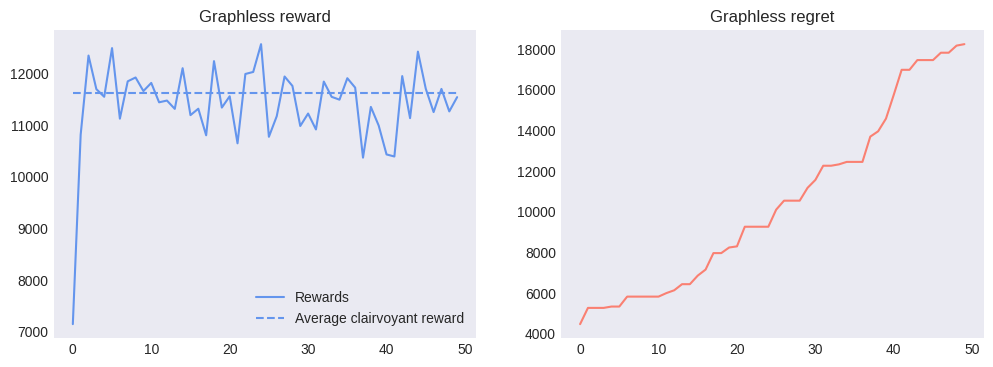

In [10]:
# Plotting the experiment
plot_experiment(sim_n_days, ts_rewards, avg_clairvoyant_reward, 'Graphless')

Here we can see a plot of the reward for each day of simulation and the corresponding regret.
As we can see the learner reaches the optimal superarm very quickly (8 days roughly). As expected from Thompson Sampling, we observe a bit of instability sometimes. This is because the MAB can occasionally choose a suboptimal arm due to the random nature of the algorithm.

Note: the reward sometimes is higher than the clairvoyant line. This something we expect since the environment leverages randomness to a certain extent. Therefore, since the clairvoyant reward is computed deterministically the reward, out of pure luck, can be higher.

# Average Behaviour
Now we compute average reward and regret (including standard deviation) over a significant number of runs.

In [11]:
# Function used for quickly plotting multiple experiments onto a graph
def plot_avg_experiments(n_days, n_rewards, avg_clairvoyant_reward, title, reward_color='cornflowerblue', regret_color='salmon', std_color='salmon'):

    avg_reward = np.average(n_rewards, axis=0)
    std_reward = np.std(n_rewards, axis=0)
    x = np.arange(n_days)

    avg_regret = avg_clairvoyant_reward - avg_reward
    avg_regret[avg_regret<0] = 0
    avg_regret = np.cumsum(avg_regret)
    
    upper_std_regret = avg_clairvoyant_reward - avg_reward + std_reward
    upper_std_regret[upper_std_regret<0] = 0
    upper_std_regret = np.cumsum(upper_std_regret)

    lower_std_regret = avg_clairvoyant_reward - avg_reward - std_reward
    lower_std_regret[lower_std_regret<0] = 0
    lower_std_regret = np.cumsum(lower_std_regret)

    clairvoyant_plot = np.ones(len(avg_reward)) * avg_clairvoyant_reward

    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

    ax[0].plot(avg_reward, color=reward_color, label='Rewards')
    ax[0].title.set_text(f'{title} average reward over {len(n_rewards)} experiments')
    ax[0].plot(clairvoyant_plot, color=reward_color, linestyle='--', label='Average clairvoyant reward')
    ax[0].legend(loc='best')

    ax[0].fill_between(x, (avg_reward-std_reward), (avg_reward+std_reward), color=std_color, alpha=.1, label= 'std')

    ax[1].plot(avg_regret, color=regret_color)
    ax[1].title.set_text(f'{title} average regret over {len(n_rewards)} experiments')

    ax[1].fill_between(x, lower_std_regret, upper_std_regret, color=std_color, alpha=.1)
        
    plt.show()

In [12]:
rng = np.random.default_rng(seed)
env = make_env(rng)

In [13]:
sim_n_experiments = 30
n_days = 50
seed = 1403

# Creating multiple simulations
simulations = create_n(
    rng,
    env,
    step=Step.THREE,
    n=sim_n_experiments,
    n_budget_steps=20,
    population_mean=1000,
    population_variance=10,
    mab_algorithm=Mab.GPTS,
)

In [14]:
ts_rewards = simulate_n(simulations, n_days)

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

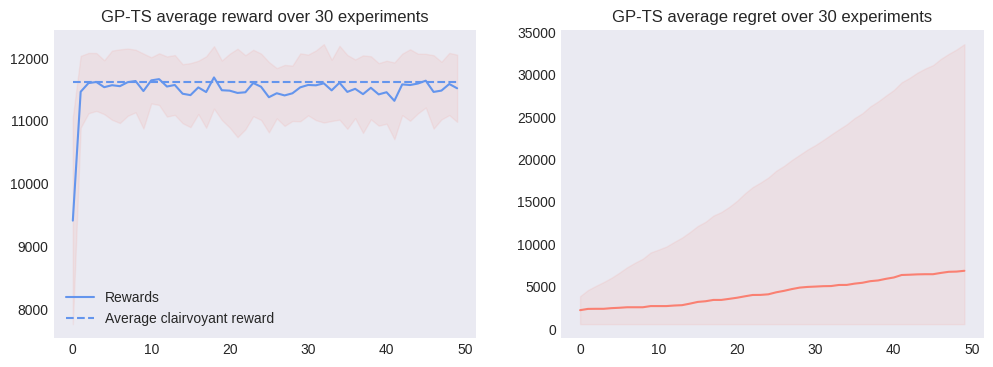

In [15]:
plot_avg_experiments(n_days, 
    ts_rewards,
    avg_clairvoyant_reward, 
    'GP-TS')

In [17]:
# Computing empiric regret
avg = np.average(ts_rewards, axis=0)
total_rew = np.sum(avg)
empiric_regret = avg_clairvoyant_reward * n_days - total_rew

print(f'Graphless empiric regret over a {n_days} days horizon: {empiric_regret}')

Graphless empiric regret over a 50 days horizon: 6626.400000000023
